In [1]:
import numpy as np
import magpylib as magpy
import pandas as pd
from magpylib.magnet import Cuboid, Cylinder, CylinderSegment
from maggeometry import n_rings, halbach_cylinder
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from maghelper import get_field_on_axes, get_nonuniformity, make_flux_stream, centered_sweep_range, get_grid_mag_and_nonuniformity, make_xy_grid

In [2]:
def calc_perf(file, startindex, endindex, numrings, savefile=False, isring=True):
    f = pd.read_csv(file)
    f = f.to_numpy()
    grid_res = 101
    grid = make_xy_grid([-10, 10], [-10, 10], grid_res)
    results_g_center = []
    results_nonun = []
    if isring:
        Br = 1.09e3
        mag_dir = (0,0,1)
        mirror_z = True
        ringset_config = [Br, mag_dir, mirror_z]
        ringset_config_nomirror = [Br, mag_dir, False]
        for x in f:
            obj_ring_config = []
            if numrings == 2:
                obj_ring_config=[[*ringset_config, *x[startindex:endindex+1]]]
            if numrings == 3:
                midindex = int((endindex+1 - startindex) / 2) + startindex
                obj_ring_config=[[*ringset_config_nomirror, *x[startindex:midindex]], [*ringset_config, *x[midindex:endindex+1]]]
            if numrings == 4:
                midindex = int((endindex+1 - startindex) / 2) + startindex
                obj_ring_config=[[*ringset_config, *x[startindex:midindex]], [*ringset_config, *x[midindex:endindex+1]]]
            magnets = n_rings(obj_ring_config)
            Gmag, Gnon, center_field, av_nonuniformity, max_abs_nonuniformity = get_grid_mag_and_nonuniformity(magnets, grid, grid_res, True)
            results_g_center.append(center_field)
            results_nonun.append(av_nonuniformity)
    else:
        Br = 1.09e3
        for x in f:
            magnets = halbach_cylinder(Br, x[startindex], c_h[0], x[endindex], n)
            Gmag, Gnon, center_field, av_nonuniformity, max_abs_nonuniformity = get_grid_mag_and_nonuniformity(magnets, grid, grid_res, True)
            results_g_center.append(center_field)
            results_nonun.append(av_nonuniformity)
    return results_g_center, results_nonun


In [3]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [5]:
def pp_make_start_finish_plots(figname, guess_nonun, guess_cf, comparison_results_file, headers, n_ringsets):

    cmp = pd.read_csv(comparison_results_file)
    cmp = cmp.to_numpy()
    cmp = np.delete(cmp, 0, 1)

    nplots = len(headers)
    fig_width = 25
    fig, axs = plt.subplots(1, nplots, figsize=(fig_width, 1/3*fig_width))
    # fig, axs = plt.subplots(1, 2)
    axs = axs.flat

    st2_width = cmp.shape[1]
    st2_nonun = cmp[:, 0]
    st2_field = cmp[:, 1]
    idx = 4 * n_ringsets + 2
    st1_nonun = cmp[:, idx]
    st1_field = cmp[:, idx+1]
    res = [[st1_nonun, st1_field], [st2_nonun, st2_field]]
    if (nplots == 3):
        res.insert(0, [guess_nonun, guess_cf])
    hfont = {'fontname':'Baskerville'}
    for i in range(nplots):
        axs[i].set_axisbelow(True)
        axs[i].axhline(10, color="green", linestyle="--", linewidth=0.5)
        axs[i].axhline(-10, color="green", linestyle="--", linewidth=0.5)
        axs[i].set_ylabel("Central field strength (Gauss)", **hfont)
        axs[i].set_xlabel("Nonuniformity", **hfont)
        axs[i].grid(color='.97', which='minor', axis='both', linestyle='-')
        axs[i].grid(color='.9', which='major', axis='both', linestyle='-')
        axs[i].set_title(headers[i], **hfont)
        axs[i].set_xscale("log")
        axs[i].scatter(res[i][0], res[i][1], s=14, color='blue', zorder=1)
        axs[i].yaxis.set_minor_locator(MultipleLocator(10))
    axs[0].yaxis.set_major_locator(MultipleLocator(200))
    axs[2].set_ylim(-20, 20)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})
    plt.savefig(figname)
    

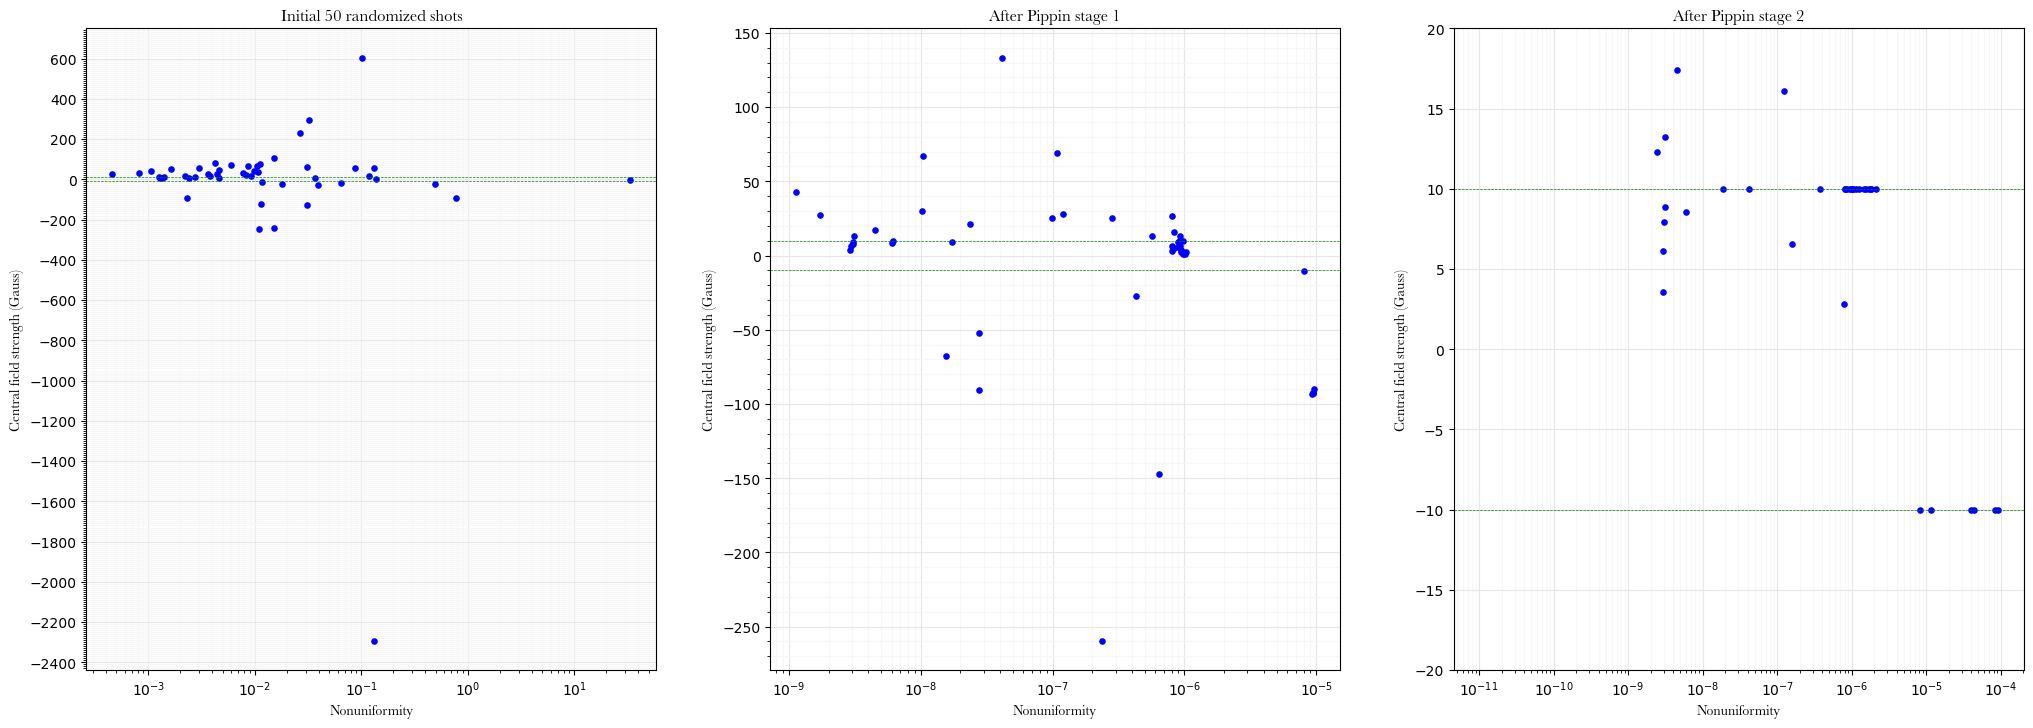

In [6]:
crf4r = 'results/4 rings/pippin/run1/2023_08_02_pippin2_4r_1090mT_comparison_50.csv'

headers =[
    "Initial 50 randomized shots",
    "After Pippin stage 1",
    "After Pippin stage 2",]
guess_cf4r, guess_nonun4r = calc_perf('results/4 rings/pippin/run1/2023_08_01_pippin1_4r_1090mT_corrected_50.csv', 11, 18, 4, True)
pp_make_start_finish_plots("figs/4rresults_pp.png", guess_nonun4r, guess_cf4r, crf4r, headers, 2)

Samwise plots

In [7]:
def sw_make_start_finish_plots(figname, guess_nonun, guess_cf, final_nonun, final_cf, headers):
    res = [[guess_nonun, guess_cf], [final_nonun, final_cf]]
    hfont = {'fontname':'Baskerville'}
    nplots = len(headers)
    fig_width = 25
    fig, axs = plt.subplots(1, nplots, figsize=(fig_width, 1/3*fig_width))
    axs = axs.flat
    for i in range(nplots):
        axs[i].set_axisbelow(True)
        axs[i].axhline(10, color="green", linestyle="--", linewidth=0.5)
        axs[i].axhline(-10, color="green", linestyle="--", linewidth=0.5)
        axs[i].set_ylabel("Central field strength (Gauss)", **hfont)
        axs[i].set_xlabel("Nonuniformity", **hfont)
        axs[i].grid(color='.97', which='minor', axis='both', linestyle='-')
        axs[i].grid(color='.9', which='major', axis='both', linestyle='-')
        axs[i].set_title(headers[i], **hfont)
        axs[i].set_xscale("log")
        axs[i].scatter(res[i][0], res[i][1], s=14, color='blue', zorder=1)
        axs[i].yaxis.set_minor_locator(MultipleLocator(10))
    axs[0].yaxis.set_major_locator(MultipleLocator(200))
    axs[1].set_ylim(-20, 20)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})
    plt.savefig(figname)

[15.913303455638301, 11.837711497070082, 107.70200212080309, 12.482144095380097, -4.472591340796459, 14.491885001865183, 111.31573611694901, 14.558603689641007, 18.084990034363543, 40.327334787951, 52.54550100739397, 30.146823928396323, 18.258182561988114, 33.80291826479104, 28.186731105229292, 78.72399197665061, 34.41854691859186, 80.84588443114512, 48.01563274345351, 4.097540690704293, 34.343913710138224, 329.0502845237973, -37.6306876646424, -61.294788979602046, -27.210838651671732, -110.96242863558402, 14.010999383113845, -281.0075324448686, -2.329104157575781, 8.412106210225119, 38.04026201309135, -289.20751451096726, 24.792847887332474, 75.2562938913803, 225.9686074845029, 41.47015753140835, 18.41261597162265, 35.07764084446589, 38.909870324150475, 260.23833511662235, 355.0370922940248, -20.729648506725233, -70.01908287435202, 98.408242142599, 59.022643307660516, 369.56714726760737, 75.35404578408603, 61.275794986587364, -283.70114067770686, 39.63337007239602]
[3.41479404262686e-

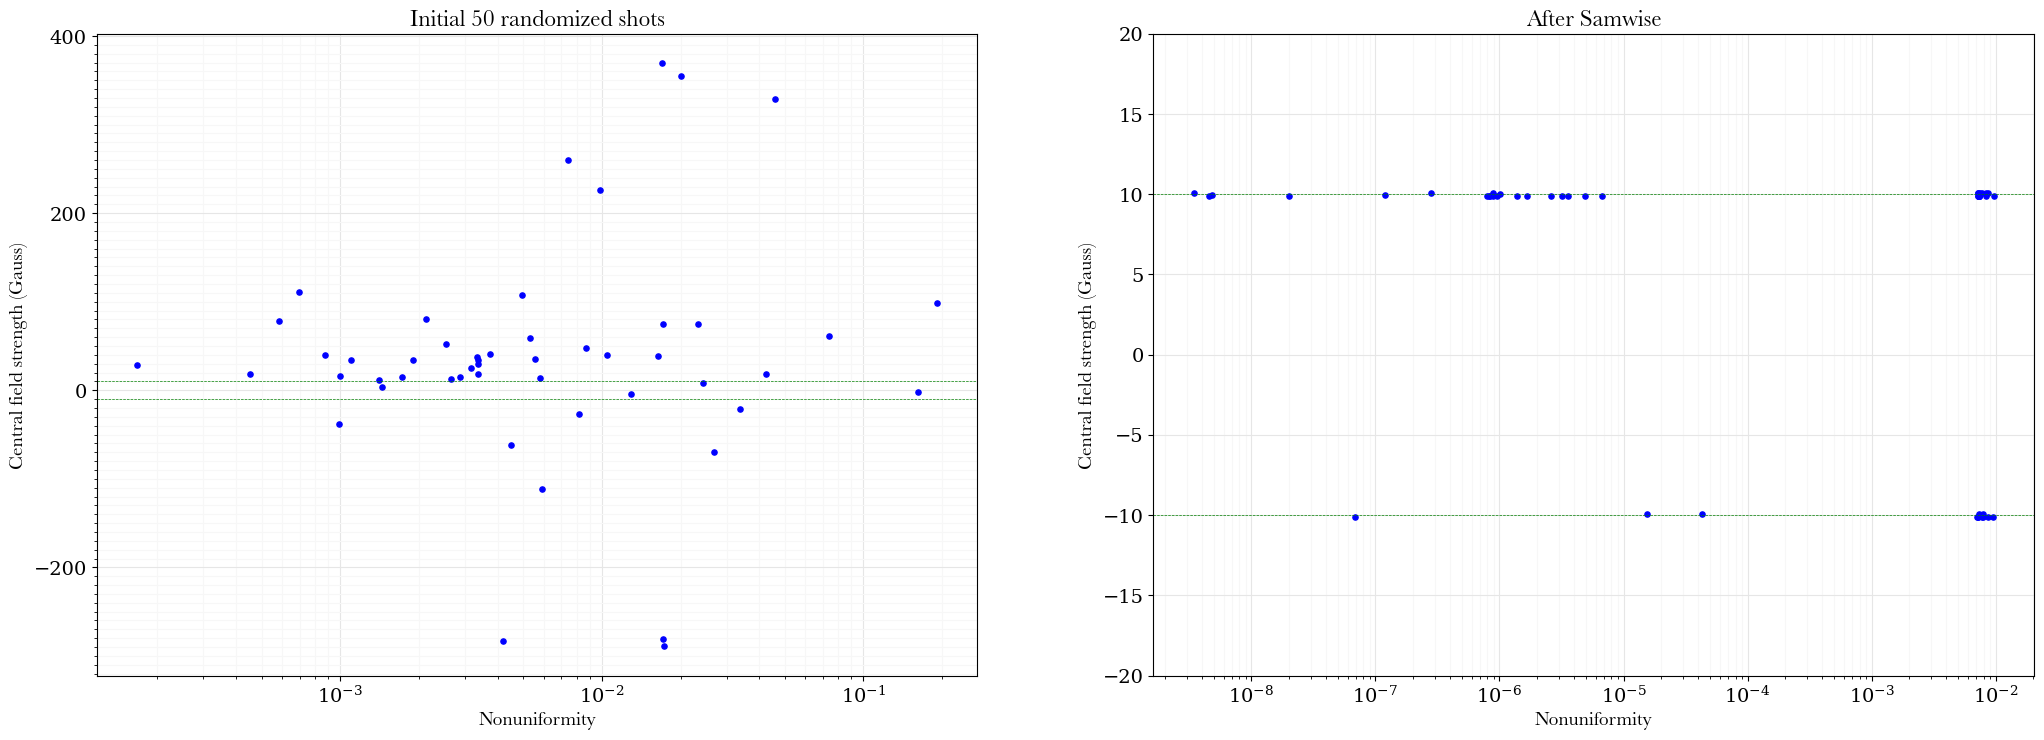

In [9]:
swheaders =[
    "Initial 50 randomized shots",
    "After Samwise",]
swres_cf3r, swres_nonun3r = calc_perf('results/4 rings/samwise/2023_07_18_samwise_10G_objective_adaptive_stage1and2opt_4rings_1090T_50.csv', 3, 10, 4, True)
swguess_cf3r, swguess_nonun3r = calc_perf('results/4 rings/samwise/2023_07_18_samwise_10G_objective_adaptive_stage1and2opt_4rings_1090T_50.csv', 11, 18, 4, True)
print (swguess_cf3r)
print(swres_nonun3r)
sw_make_start_finish_plots("figs/4rresults_sw.png", swguess_nonun3r, swguess_cf3r, swres_nonun3r, swres_cf3r, swheaders)